# Working with Text

Packages that are being used in this notebook:

In [1]:
from importlib.metadata import version

print("torch version:", version("torch"))
print("tiktoken version:", version("tiktoken"))

torch version: 2.2.2
tiktoken version: 0.8.0


- This chapter covers data preparation and sampling to get input data "ready" for the LLM

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch02_compressed/01.webp?timestamp=1" width="500px">

## 2.1 Understanding word embeddings

- No code in this section

- There are many forms of embeddings; we focus on text embeddings in this book

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch02_compressed/02.webp" width="500px">

- LLMs work with embeddings in high-dimensional spaces (i.e., thousands of dimensions)
- Since we can't visualize such high-dimensional spaces (we humans think in 1, 2, or 3 dimensions), the figure below illustrates a 2-dimensional embedding space

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch02_compressed/03.webp" width="300px">

## 2.2 Tokenizing text

- In this section, we tokenize text, which means breaking text into smaller units, such as individual words and punctuation characters

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch02_compressed/04.webp" width="300px">

- Load raw text we want to work with
- [The Verdict by Edith Wharton](https://en.wikisource.org/wiki/The_Verdict) is a public domain short story

In [2]:
import os
import urllib.request

if not os.path.exists("the-verdict.txt"):
    url = ("https://raw.githubusercontent.com/rasbt/"
           "LLMs-from-scratch/main/ch02/01_main-chapter-code/"
           "the-verdict.txt")
    file_path = "the-verdict.txt"
    urllib.request.urlretrieve(url, file_path)

In [3]:
with open("the-verdict.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()
    
print("Total number of character:", len(raw_text))
print(raw_text[:99])

Total number of character: 20479
I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no 


- The goal is to tokenize and embed this text for an LLM
- Let's develop a simple tokenizer based on some simple sample text that we can then later apply to the text above
- The following regular expression will split on whitespaces

In [4]:
import re

text = "Hello, world. This, is a test."
result = re.split(r'(\s)', text)

print(result)

['Hello,', ' ', 'world.', ' ', 'This,', ' ', 'is', ' ', 'a', ' ', 'test.']


- We don't only want to split on whitespaces but also commas and periods, so let's modify the regular expression to do that as well

In [5]:
result = re.split(r'([,.]|\s)', text)

print(result)

['Hello', ',', '', ' ', 'world', '.', '', ' ', 'This', ',', '', ' ', 'is', ' ', 'a', ' ', 'test', '.', '']


- As we can see, this creates empty strings, let's remove them

In [6]:
# Strip whitespace from each item and then filter out any empty strings.
result = [item for item in result if item.strip()]
print(result)

['Hello', ',', 'world', '.', 'This', ',', 'is', 'a', 'test', '.']


- This looks pretty good, but let's also handle other types of punctuation, such as periods, question marks, and so on

In [7]:
text = "Hello, world. Is this-- a test?"

result = re.split(r'([,.:;?_!"()\']|--|\s)', text)
result = [item.strip() for item in result if item.strip()]
print(result)

['Hello', ',', 'world', '.', 'Is', 'this', '--', 'a', 'test', '?']


- This is pretty good, and we are now ready to apply this tokenization to the raw text

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch02_compressed/05.webp" width="350px">

In [8]:
preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', raw_text)
preprocessed = [item.strip() for item in preprocessed if item.strip()]
print(preprocessed[:30])

['I', 'HAD', 'always', 'thought', 'Jack', 'Gisburn', 'rather', 'a', 'cheap', 'genius', '--', 'though', 'a', 'good', 'fellow', 'enough', '--', 'so', 'it', 'was', 'no', 'great', 'surprise', 'to', 'me', 'to', 'hear', 'that', ',', 'in']


- Let's calculate the total number of tokens

In [9]:
print(len(preprocessed))

4690


## 2.3 Converting tokens into token IDs

- Next, we convert the text tokens into token IDs that we can process via embedding layers later

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch02_compressed/06.webp" width="500px">

- From these tokens, we can now build a vocabulary that consists of all the unique tokens

In [10]:
all_words = sorted(set(preprocessed))
vocab_size = len(all_words)

print(vocab_size)

1130


In [11]:
vocab = {token:integer for integer,token in enumerate(all_words)}

- Below are the first 50 entries in this vocabulary:

In [12]:
for i, item in enumerate(vocab.items()):
    print(item)
    if i >= 50:
        break

('!', 0)
('"', 1)
("'", 2)
('(', 3)
(')', 4)
(',', 5)
('--', 6)
('.', 7)
(':', 8)
(';', 9)
('?', 10)
('A', 11)
('Ah', 12)
('Among', 13)
('And', 14)
('Are', 15)
('Arrt', 16)
('As', 17)
('At', 18)
('Be', 19)
('Begin', 20)
('Burlington', 21)
('But', 22)
('By', 23)
('Carlo', 24)
('Chicago', 25)
('Claude', 26)
('Come', 27)
('Croft', 28)
('Destroyed', 29)
('Devonshire', 30)
('Don', 31)
('Dubarry', 32)
('Emperors', 33)
('Florence', 34)
('For', 35)
('Gallery', 36)
('Gideon', 37)
('Gisburn', 38)
('Gisburns', 39)
('Grafton', 40)
('Greek', 41)
('Grindle', 42)
('Grindles', 43)
('HAD', 44)
('Had', 45)
('Hang', 46)
('Has', 47)
('He', 48)
('Her', 49)
('Hermia', 50)


- Below, we illustrate the tokenization of a short sample text using a small vocabulary:

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch02_compressed/07.webp?123" width="500px">

- Putting it now all together into a tokenizer class

In [13]:
class SimpleTokenizerV1:
    def __init__(self, vocab):
        self.str_to_int = vocab
        self.int_to_str = {i:s for s,i in vocab.items()}
    
    def encode(self, text):
        preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', text)
                                
        preprocessed = [
            item.strip() for item in preprocessed if item.strip()
        ]
        ids = [self.str_to_int[s] for s in preprocessed]
        return ids
        
    def decode(self, ids):
        text = " ".join([self.int_to_str[i] for i in ids])
        # Replace spaces before the specified punctuations
        text = re.sub(r'\s+([,.?!"()\'])', r'\1', text)
        return text

- The `encode` function turns text into token IDs
- The `decode` function turns token IDs back into text

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch02_compressed/08.webp?123" width="500px">

- We can use the tokenizer to encode (that is, tokenize) texts into integers
- These integers can then be embedded (later) as input of/for the LLM

In [14]:
tokenizer = SimpleTokenizerV1(vocab)

text = """"It's the last he painted, you know," 
           Mrs. Gisburn said with pardonable pride."""
ids = tokenizer.encode(text)
print(ids)

[1, 56, 2, 850, 988, 602, 533, 746, 5, 1126, 596, 5, 1, 67, 7, 38, 851, 1108, 754, 793, 7]


- We can decode the integers back into text

In [15]:
tokenizer.decode(ids)

'" It\' s the last he painted, you know," Mrs. Gisburn said with pardonable pride.'

In [16]:
tokenizer.decode(tokenizer.encode(text))

'" It\' s the last he painted, you know," Mrs. Gisburn said with pardonable pride.'

## 2.4 Adding special context tokens

- It's useful to add some "special" tokens for unknown words and to denote the end of a text

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch02_compressed/09.webp?123" width="500px">

- Some tokenizers use special tokens to help the LLM with additional context
- Some of these special tokens are
  - `[BOS]` (beginning of sequence) marks the beginning of text
  - `[EOS]` (end of sequence) marks where the text ends (this is usually used to concatenate multiple unrelated texts, e.g., two different Wikipedia articles or two different books, and so on)
  - `[PAD]` (padding) if we train LLMs with a batch size greater than 1 (we may include multiple texts with different lengths; with the padding token we pad the shorter texts to the longest length so that all texts have an equal length)
- `[UNK]` to represent words that are not included in the vocabulary

- Note that GPT-2 does not need any of these tokens mentioned above but only uses an `<|endoftext|>` token to reduce complexity
- The `<|endoftext|>` is analogous to the `[EOS]` token mentioned above
- GPT also uses the `<|endoftext|>` for padding (since we typically use a mask when training on batched inputs, we would not attend padded tokens anyways, so it does not matter what these tokens are)
- GPT-2 does not use an `<UNK>` token for out-of-vocabulary words; instead, GPT-2 uses a byte-pair encoding (BPE) tokenizer, which breaks down words into subword units which we will discuss in a later section



- We use the `<|endoftext|>` tokens between two independent sources of text:

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch02_compressed/10.webp" width="500px">

- Let's see what happens if we tokenize the following text:

In [17]:
tokenizer = SimpleTokenizerV1(vocab)

text = "Hello, do you like tea. Is this-- a test?"

tokenizer.encode(text)

KeyError: 'Hello'

- The above produces an error because the word "Hello" is not contained in the vocabulary
- To deal with such cases, we can add special tokens like `"<|unk|>"` to the vocabulary to represent unknown words
- Since we are already extending the vocabulary, let's add another token called `"<|endoftext|>"` which is used in GPT-2 training to denote the end of a text (and it's also used between concatenated text, like if our training datasets consists of multiple articles, books, etc.)

In [18]:
all_tokens = sorted(list(set(preprocessed)))
all_tokens.extend(["<|endoftext|>", "<|unk|>"])

vocab = {token:integer for integer,token in enumerate(all_tokens)}

In [19]:
len(vocab.items())

1132

In [20]:
for i, item in enumerate(list(vocab.items())[-5:]):
    print(item)

('younger', 1127)
('your', 1128)
('yourself', 1129)
('<|endoftext|>', 1130)
('<|unk|>', 1131)


- We also need to adjust the tokenizer accordingly so that it knows when and how to use the new `<unk>` token

In [21]:
class SimpleTokenizerV2:
    def __init__(self, vocab):
        self.str_to_int = vocab
        self.int_to_str = { i:s for s,i in vocab.items()}
    
    def encode(self, text):
        preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', text)
        preprocessed = [item.strip() for item in preprocessed if item.strip()]
        preprocessed = [
            item if item in self.str_to_int 
            else "<|unk|>" for item in preprocessed
        ]

        ids = [self.str_to_int[s] for s in preprocessed]
        return ids
        
    def decode(self, ids):
        text = " ".join([self.int_to_str[i] for i in ids])
        # Replace spaces before the specified punctuations
        text = re.sub(r'\s+([,.:;?!"()\'])', r'\1', text)
        return text

Let's try to tokenize text with the modified tokenizer:

In [22]:
tokenizer = SimpleTokenizerV2(vocab)

text1 = "Hello, do you like tea?"
text2 = "In the sunlit terraces of the palace."

text = " <|endoftext|> ".join((text1, text2))

print(text)

Hello, do you like tea? <|endoftext|> In the sunlit terraces of the palace.


In [23]:
tokenizer.encode(text)

[1131, 5, 355, 1126, 628, 975, 10, 1130, 55, 988, 956, 984, 722, 988, 1131, 7]

In [24]:
tokenizer.decode(tokenizer.encode(text))

'<|unk|>, do you like tea? <|endoftext|> In the sunlit terraces of the <|unk|>.'

## 2.5 BytePair encoding

- GPT-2 used BytePair encoding (BPE) as its tokenizer
- it allows the model to break down words that aren't in its predefined vocabulary into smaller subword units or even individual characters, enabling it to handle out-of-vocabulary words
- For instance, if GPT-2's vocabulary doesn't have the word "unfamiliarword," it might tokenize it as ["unfam", "iliar", "word"] or some other subword breakdown, depending on its trained BPE merges
- The original BPE tokenizer can be found here: [https://github.com/openai/gpt-2/blob/master/src/encoder.py](https://github.com/openai/gpt-2/blob/master/src/encoder.py)
- In this chapter, we are using the BPE tokenizer from OpenAI's open-source [tiktoken](https://github.com/openai/tiktoken) library, which implements its core algorithms in Rust to improve computational performance
- I created a notebook in the [./bytepair_encoder](../02_bonus_bytepair-encoder) that compares these two implementations side-by-side (tiktoken was about 5x faster on the sample text)

In [25]:
# pip install tiktoken

In [26]:
import importlib
import tiktoken

print("tiktoken version:", importlib.metadata.version("tiktoken"))

tiktoken version: 0.8.0


In [27]:
tokenizer = tiktoken.get_encoding("gpt2")

In [28]:
text = (
    "Hello, do you like tea? <|endoftext|> In the sunlit terraces"
     "of someunknownPlace."
)

integers = tokenizer.encode(text, allowed_special={"<|endoftext|>"})

print(integers)

[15496, 11, 466, 345, 588, 8887, 30, 220, 50256, 554, 262, 4252, 18250, 8812, 2114, 1659, 617, 34680, 27271, 13]


In [29]:
strings = tokenizer.decode(integers)

print(strings)

Hello, do you like tea? <|endoftext|> In the sunlit terracesof someunknownPlace.


- BPE tokenizers break down unknown words into subwords and individual characters:

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch02_compressed/11.webp" width="300px">

## 2.6 Data sampling with a sliding window

- We train LLMs to generate one word at a time, so we want to prepare the training data accordingly where the next word in a sequence represents the target to predict:

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch02_compressed/12.webp" width="400px">

In [30]:
with open("the-verdict.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()

enc_text = tokenizer.encode(raw_text)
print(len(enc_text))

5145


- For each text chunk, we want the inputs and targets
- Since we want the model to predict the next word, the targets are the inputs shifted by one position to the right

In [31]:
enc_sample = enc_text[50:]

In [32]:
context_size = 4

x = enc_sample[:context_size]
y = enc_sample[1:context_size+1]

print(f"x: {x}")
print(f"y:      {y}")

x: [290, 4920, 2241, 287]
y:      [4920, 2241, 287, 257]


- One by one, the prediction would look like as follows:

In [33]:
for i in range(1, context_size+1):
    context = enc_sample[:i]
    desired = enc_sample[i]

    print(context, "---->", desired)

[290] ----> 4920
[290, 4920] ----> 2241
[290, 4920, 2241] ----> 287
[290, 4920, 2241, 287] ----> 257


In [34]:
for i in range(1, context_size+1):
    context = enc_sample[:i]
    desired = enc_sample[i]

    print(tokenizer.decode(context), "---->", tokenizer.decode([desired]))

 and ---->  established
 and established ---->  himself
 and established himself ---->  in
 and established himself in ---->  a


- We will take care of the next-word prediction in a later chapter after we covered the attention mechanism
- For now, we implement a simple data loader that iterates over the input dataset and returns the inputs and targets shifted by one

- Install and import PyTorch (see Appendix A for installation tips)

In [35]:
import torch
print("PyTorch version:", torch.__version__)

PyTorch version: 2.2.2


- We use a sliding window approach, changing the position by +1:

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch02_compressed/13.webp?123" width="500px">

- Create dataset and dataloader that extract chunks from the input text dataset

In [36]:
from torch.utils.data import Dataset, DataLoader


class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        # Tokenize the entire text
        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})

        # Use a sliding window to chunk the book into overlapping sequences of max_length
        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]

In [37]:
def create_dataloader_v1(txt, batch_size=4, max_length=256, 
                         stride=128, shuffle=True, drop_last=True,
                         num_workers=0):

    # Initialize the tokenizer
    tokenizer = tiktoken.get_encoding("gpt2")

    # Create dataset
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)

    # Create dataloader
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers
    )

    return dataloader

- Let's test the dataloader with a batch size of 1 for an LLM with a context size of 4:

In [38]:
with open("the-verdict.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()

In [39]:
dataloader = create_dataloader_v1(
    raw_text, batch_size=1, max_length=4, stride=1, shuffle=False
)

data_iter = iter(dataloader)
first_batch = next(data_iter)
print(first_batch)

[tensor([[  40,  367, 2885, 1464]]), tensor([[ 367, 2885, 1464, 1807]])]


In [40]:
second_batch = next(data_iter)
print(second_batch)

[tensor([[ 367, 2885, 1464, 1807]]), tensor([[2885, 1464, 1807, 3619]])]


- An example using stride equal to the context length (here: 4) as shown below:

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch02_compressed/14.webp" width="500px">

- We can also create batched outputs
- Note that we increase the stride here so that we don't have overlaps between the batches, since more overlap could lead to increased overfitting

In [41]:
dataloader = create_dataloader_v1(raw_text, batch_size=8, max_length=4, stride=4, shuffle=False)

data_iter = iter(dataloader)
inputs, targets = next(data_iter)
print("Inputs:\n", inputs)
print("\nTargets:\n", targets)

Inputs:
 tensor([[   40,   367,  2885,  1464],
        [ 1807,  3619,   402,   271],
        [10899,  2138,   257,  7026],
        [15632,   438,  2016,   257],
        [  922,  5891,  1576,   438],
        [  568,   340,   373,   645],
        [ 1049,  5975,   284,   502],
        [  284,  3285,   326,    11]])

Targets:
 tensor([[  367,  2885,  1464,  1807],
        [ 3619,   402,   271, 10899],
        [ 2138,   257,  7026, 15632],
        [  438,  2016,   257,   922],
        [ 5891,  1576,   438,   568],
        [  340,   373,   645,  1049],
        [ 5975,   284,   502,   284],
        [ 3285,   326,    11,   287]])


## 2.7 Creating token embeddings

- The data is already almost ready for an LLM
- But lastly let us embed the tokens in a continuous vector representation using an embedding layer
- Usually, these embedding layers are part of the LLM itself and are updated (trained) during model training

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch02_compressed/15.webp" width="400px">

- Suppose we have the following four input examples with input ids 2, 3, 5, and 1 (after tokenization):

In [42]:
input_ids = torch.tensor([2, 3, 5, 1])

- For the sake of simplicity, suppose we have a small vocabulary of only 6 words and we want to create embeddings of size 3:

In [43]:
vocab_size = 6
output_dim = 3

torch.manual_seed(123)
embedding_layer = torch.nn.Embedding(vocab_size, output_dim)

- This would result in a 6x3 weight matrix:

In [44]:
print(embedding_layer.weight)

Parameter containing:
tensor([[ 0.3374, -0.1778, -0.1690],
        [ 0.9178,  1.5810,  1.3010],
        [ 1.2753, -0.2010, -0.1606],
        [-0.4015,  0.9666, -1.1481],
        [-1.1589,  0.3255, -0.6315],
        [-2.8400, -0.7849, -1.4096]], requires_grad=True)


- For those who are familiar with one-hot encoding, the embedding layer approach above is essentially just a more efficient way of implementing one-hot encoding followed by matrix multiplication in a fully-connected layer, which is described in the supplementary code in [./embedding_vs_matmul](../03_bonus_embedding-vs-matmul)
- Because the embedding layer is just a more efficient implementation that is equivalent to the one-hot encoding and matrix-multiplication approach it can be seen as a neural network layer that can be optimized via backpropagation

- To convert a token with id 3 into a 3-dimensional vector, we do the following:

In [45]:
print(embedding_layer(torch.tensor([3])))

tensor([[-0.4015,  0.9666, -1.1481]], grad_fn=<EmbeddingBackward0>)


- Note that the above is the 4th row in the `embedding_layer` weight matrix
- To embed all four `input_ids` values above, we do

In [46]:
print(embedding_layer(input_ids))

tensor([[ 1.2753, -0.2010, -0.1606],
        [-0.4015,  0.9666, -1.1481],
        [-2.8400, -0.7849, -1.4096],
        [ 0.9178,  1.5810,  1.3010]], grad_fn=<EmbeddingBackward0>)


- An embedding layer is essentially a look-up operation:

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch02_compressed/16.webp?123" width="500px">

- **You may be interested in the bonus content comparing embedding layers with regular linear layers: [../03_bonus_embedding-vs-matmul](../03_bonus_embedding-vs-matmul)**

## 2.8 Encoding word positions

- Embedding layer convert IDs into identical vector representations regardless of where they are located in the input sequence:

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch02_compressed/17.webp" width="400px">

- Positional embeddings are combined with the token embedding vector to form the input embeddings for a large language model:

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch02_compressed/18.webp" width="500px">

- The BytePair encoder has a vocabulary size of 50,257:
- Suppose we want to encode the input tokens into a 256-dimensional vector representation:

In [47]:
vocab_size = 50257
output_dim = 256

token_embedding_layer = torch.nn.Embedding(vocab_size, output_dim)

- If we sample data from the dataloader, we embed the tokens in each batch into a 256-dimensional vector
- If we have a batch size of 8 with 4 tokens each, this results in a 8 x 4 x 256 tensor:

In [48]:
max_length = 4
dataloader = create_dataloader_v1(
    raw_text, batch_size=8, max_length=max_length,
    stride=max_length, shuffle=False
)
data_iter = iter(dataloader)
inputs, targets = next(data_iter)

In [49]:
print("Token IDs:\n", inputs)
print("\nInputs shape:\n", inputs.shape)

Token IDs:
 tensor([[   40,   367,  2885,  1464],
        [ 1807,  3619,   402,   271],
        [10899,  2138,   257,  7026],
        [15632,   438,  2016,   257],
        [  922,  5891,  1576,   438],
        [  568,   340,   373,   645],
        [ 1049,  5975,   284,   502],
        [  284,  3285,   326,    11]])

Inputs shape:
 torch.Size([8, 4])


In [50]:
token_embeddings = token_embedding_layer(inputs)
print(token_embeddings.shape)

torch.Size([8, 4, 256])


- GPT-2 uses absolute position embeddings, so we just create another embedding layer:

In [51]:
context_length = max_length
pos_embedding_layer = torch.nn.Embedding(context_length, output_dim)

In [52]:
pos_embeddings = pos_embedding_layer(torch.arange(max_length))
print(pos_embeddings.shape)

torch.Size([4, 256])


- To create the input embeddings used in an LLM, we simply add the token and the positional embeddings:

In [53]:
input_embeddings = token_embeddings + pos_embeddings
print(input_embeddings.shape)

torch.Size([8, 4, 256])


- In the initial phase of the input processing workflow, the input text is segmented into separate tokens
- Following this segmentation, these tokens are transformed into token IDs based on a predefined vocabulary:

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch02_compressed/19.webp" width="400px">

# EXERCISES

# 1. Try the BPE tokenizer from the tiktoken library on the unknown words "Akwirw ier" and print the individual token IDs. Then, call the decode function on each of the resulting integers in this list to produce a mapping from tokens to token IDs as in the image below. Lastly, call the decode method on the token IDs to check whether it can reconstruct the original input, "Akwirw ier". 
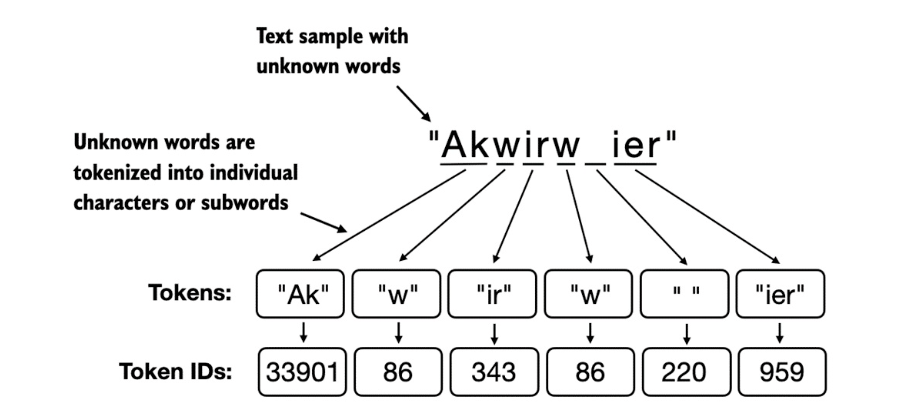